# Homework 3

Solve exercises 8.6, 9.7, 9.8, 9.9 and 9.10.

We start by copying all the functions from the last homework. We will use them for comparison with the new ones.

In [1]:
function LU(A)
    n, m = size(A) # A is supposed to be a square matrix, so hopefully n and m will be equal.
    
    # We initalize L with zeros and U to be the same as A.
    L = zeros(n,m)
    U = copy(A)
    
    for k in 1:n
        L[k,k] = 1
        for i in (k+1):n
            L[i,k] = U[i,k]/U[k,k]
            U[i,:] = U[i,:] - L[i,k]*U[k,:]
        end
    end
    return L, U
end

function backward_substitute(U,y)
    n, m = size(U)
    r, = size(y)
    @assert n == m == r
    x = zeros(n)
    
    for i in n:-1:1
        tail = 0
        for j in i+1:n
            tail = tail + U[i,j]*x[j]
        end
        x[i] = (y[i] - tail)/U[i,i]
    end
    
    return x
end

function forward_substitute(L,y)
    n, m = size(L)
    r, = size(y)
    @assert n == m == r
    x = zeros(n)
    for i in 1:n
        tail = 0
        for j in 1:i-1
            tail = tail + L[i,j]*x[j]
        end
        x[i] = (y[i] - tail)/L[i,i]
    end
    return x
end

function solve(A,f)
    n, m = size(A)
    r, = size(f)
    @assert n == m == r
    
    L, U = LU(A)
    y = forward_substitute(L,f)
    x = backward_substitute(U,y)
    
    return(x)
end

function big_matrix(n)
    A = zeros(n^2,n^2)
    for i in 1:n^2
        A[i,i] = 4
        if mod(i,n)!=0
            A[i+1,i] = -1
            A[i,i+1] = -1
        end
        if i<=n^2-n
            A[i,i+n] = -1
            A[i+n,i] = -1
        end
    end
    return A
end

function big_rhs(n, f)
    y = zeros(n^2)
    for i in 1:n
        y[i] += f(i/(n+1),0.)
        y[n^2-n+i] += f(i/(n+1),1.)
    end
        
    for i in 1:n
        y[n*i] += f(1.,i/(n+1))
        y[n*i-n+1] += f(0.,i/(n+1))
    end
    return y
end

big_rhs (generic function with 1 method)

We are going to solve the elastic membrane problem with various methods and compare the results. Recall that the problem consists in looking for values $u_{i,j}$ in some mesh so that
$$ \begin{cases} 
u_{i,j} = f\left( \frac i {n+1},\frac j {n+1} \right) & \text{if either $i$ or $j$ is equal to either $0$ or $N+1$}, \\
4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1} = 0 & \text{otherwise} \end{cases} $$

It is a system of $n \times n$ linear equations. In order to apply Gaussian Elimination, we wrote it as an $n^2 \times n^2$ matrix (provided by the function `big_matrix(n)`) that applies to the vector $(u_{1,1},\dots, u_{1,n},u_{2,1},u_{2,2},\dots,u_{n,n})$.

I am not too happy about writing the elements of a 2-dimensional mesh of points as a one-dimensional vector in $\mathbb R^{n^2}$. How about we better search for a vector $u$ that is an $n \times n$ matrix. We define the linear transformation $T : \mathbb R^{n \times n} \to \mathbb R^{n \times n}$ given by
$$ T(\{u_{i,j}\}) = 4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1},$$
with the caveat that we do not subtract any term that falls outside of the $1..n \times 1..n$ mesh. Thus, the system becomes
$$ Tu = b, $$
where 
$$ b_{i,j} = \begin{cases}
f\left( 0,\frac i {n+1} \right) & \text{ if } j=1, \\
f\left( 1,\frac i {n+1} \right) & \text{ if } j=n, \\
f\left( \frac j {n+1}, 0 \right) & \text{ if } i=1, \\
f\left( \frac j {n+1}, 1 \right) & \text{ if } i=n, \\
0 & \text{otherwise}.
\end{cases} $$

The linear operator $T$ is easy to write as a function. Also the right hand side $b$. Here they are.

In [2]:
function T(u::Array{<:Real,2})
    n, m = size(u)
    v = similar(u) # This line creates another array with the same dimensions and type as u
    for i in 1:n
        for j in 1:m
            v[i,j] = 4*u[i,j]
            if i>1 v[i,j] -= u[i-1,j] end
            if i<n v[i,j] -= u[i+1,j] end
            if j>1 v[i,j] -= u[i,j-1] end
            if j<m v[i,j] -= u[i,j+1] end
        end
    end
    return v
end

function matrix_rhs(n::Integer, f::Function)
    b = zeros(n,n)
    for i in 1:n
        b[1,i] += f(0.,i/(n+1))
        b[n,i] += f(1.,i/(n+1))
        b[i,1] += f(i/(n+1),0.)
        b[i,n] += f(i/(n+1),1.)
    end
    return b
end        

matrix_rhs (generic function with 1 method)

A convenient feature about iterative methods is that we do not need to have the matrix stored anywhere. We may solve the system with the required linear transformations written as functions.

Let us try Jacobi iteration first. We need two functions. One of them is the inverse of the diagonal, and the other is everything off-diagonal. They would be the following.

In [3]:
inverse_diagonal(u) = 0.25 * u

function off_diagonal(u::Array{<:Real,2})
    n, m = size(u)
    v = zeros(n,m)
    for i in 1:n
        for j in 1:m
            if i>1 v[i,j] -= u[i-1,j] end
            if i<n v[i,j] -= u[i+1,j] end
            if j>1 v[i,j] -= u[i,j-1] end
            if j<m v[i,j] -= u[i,j+1] end
        end
    end
    return v
end

function jacobi(u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    for i in 1:iterations
        u = inverse_diagonal(b - off_diagonal(u))
    end
    return u
end

jacobi (generic function with 1 method)

Let us try it and compare with Gaussian elimination.

Accuracy of Gaussian elimination: 4.996003610813204e-18
Accuracy of Jacobi with 500 iterations: 3.9597175497674273e-7


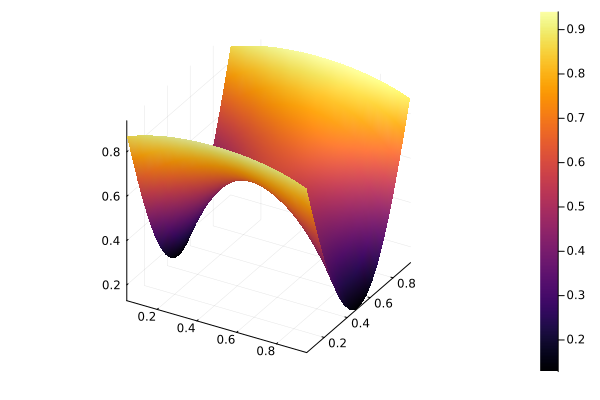

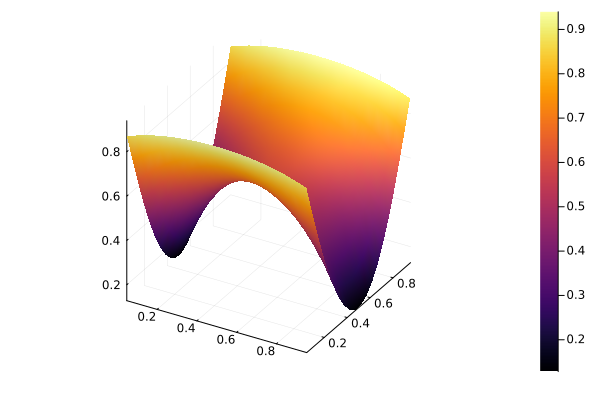

In [4]:
using Plots
n = 20
f(x,y) = 1 - sin(pi*x)
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)

# We use the following function to roughly measure the size of vectors or matrices.
function supnorm(u)
    s = 0
    for entry in u
        s = max(abs(entry),s)
    end
    return s
end

# Using Gaussian elimination
y = big_rhs(n,f)
A = big_matrix(n)
x = solve(A,y)
membrane = reshape(x,n,n)
sg = surface(partition,partition,membrane)
println("Accuracy of Gaussian elimination: ", supnorm(A*x-y) / n^2)

# Using Jacobi iteration
# We can test different number of iterations
iterations = 500
b = matrix_rhs(n,f)
u = zeros(n,n) # We take an initial guess that is identically zero.
u = jacobi(u,b,iterations)
println("Accuracy of Jacobi with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
sj = surface(partition,partition,u)
display(sg)
display(sj)

It would take more iterations for the Jacobi method to give us a solution as accurate as Gaussian elimination. But is that a bad thing? Maybe we do not want such an accurate solution. Iterative methods give us a choice of speed vs accuracy. We do not have that choice in all-or-nothin Gaussian elimination.

Let us implement Gauss-Seidel now.

In [5]:
# As before, we do not want to use the bigmatrix. 
# We implement the iteration of the Gauss-Seidel method as a function. 
# If you write it efficiently, it should modify the values of u in place, without the need of using more memory
# for intermediate computations.

function gauss_seidel_iteration!(u::Array{<:Real,2}, b::Array{<:Real,2})
    n, m = size(u)
    for i in 1:n
        for j in 1:m
            s = b[i,j]
            if i>1 s += u[i-1,j] end
            if j>1 s += u[i,j-1] end
            if i<n s += u[i+1,j] end
            if j<m s += u[i,j+1] end
            u[i,j] = s/4
        end
    end
end    

function gauss_seidel(u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    for i in 1:iterations
        gauss_seidel_iteration!(u,b)
    end
    return u
end    

gauss_seidel (generic function with 1 method)

Let us test it

Accuracy of Gauss Seidel with 500 iterations: 1.4844509393929783e-9


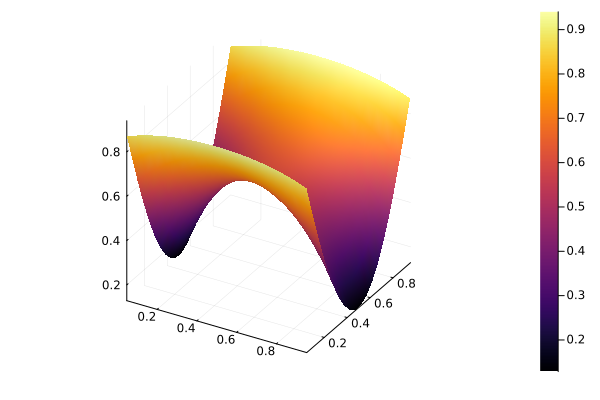

In [6]:
# Using Gauss-Seidel iteration
# We can test different number of iterations
iterations = 500
b = matrix_rhs(n,f)
u = zeros(n,n) # We take an initial guess that is identically zero.
u = gauss_seidel(u,b,iterations)
println("Accuracy of Gauss Seidel with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
sgs = surface(partition,partition,u)
display(sgs)

With 500 iterations, I got a more accurate answer with Gauss-Seidel than with Jacobi iteration, but not as accurate as with Gaussian elimination.

Let us implement the gradient descent method now. For that, we should only need the functions `T` defined above (that we have not even used yet) and `matrix_rhs`. For your convenience, I provide an function computing the dot product of two "vectors" that are expressed as 2-dimensional arrays.

In [7]:
function dot_product(u::Array{<:Real,2}, v::Array{<:Real,2})
    return sum(u.*v)
end

function gradient_descent(u::Array{<:Real,2}, b::Array{<:Real,2}, iterations::Integer)
    for i in 1:iterations
        r = T(u) - b
        a = dot_product(r,r) / dot_product(T(r),r)
        u = u - a*r
    end
    return u
end

gradient_descent (generic function with 1 method)

Time to test it.

Accuracy of Gradient descent with 500 iterations: 5.496194436355184e-7


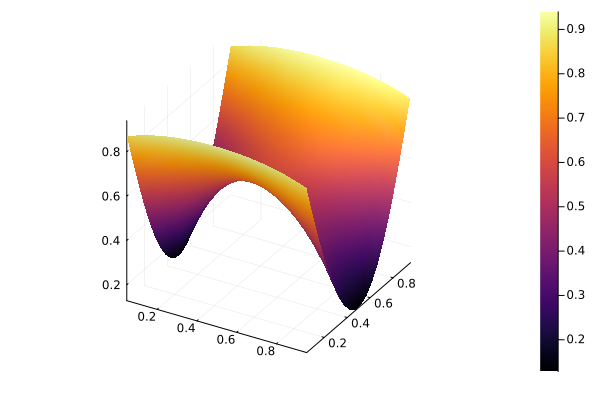

In [8]:
# Using Gradient descent
# We can test different number of iterations
iterations = 500
b = matrix_rhs(n,f)
u = zeros(n,n) # We take an initial guess that is identically zero.
u = gradient_descent(u,b,iterations)
println("Accuracy of Gradient descent with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
sgd = surface(partition,partition,u)
display(sgd)

The accuracy I got for gradient descent in this case is similar as for Jacobi iteration. 

Let us test how long these algorithms take in practice. So, we will time their execution time with a 40x40 mesh.

In [9]:
n = 40
f(x,y) = 1 - sin(pi*x)
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)

# Using Gaussian elimination
y = big_rhs(n,f)
A = big_matrix(n)
@time x = solve(A,y)
println("Accuracy of Gaussian elimination: ", supnorm(A*x-y) / n^2)
println()

# Using Jacobi iteration
iterations = 500
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = jacobi(u,b,iterations)
println("Accuracy of Jacobi with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()

# Using Jacobi iteration with more iterations
iterations = 5000
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = jacobi(u,b,iterations)
println("Accuracy of Jacobi with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()

# Using Gauss-Seidel iteration
# We can test different number of iterations
iterations = 500
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gauss_seidel(u,b,iterations)
println("Accuracy of Gauss Seidel with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()

# Using Gauss-Seidel iteration
# We can test different number of iterations
iterations = 5000
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gauss_seidel(u,b,iterations)
println("Accuracy of Gauss Seidel with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()

# Using Gradient descent
# We can test different number of iterations
iterations = 500
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gradient_descent(u,b,iterations)
println("Accuracy of Gradient descent with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()

# Using Gradient descent
# We can test different number of iterations
iterations = 5000
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gradient_descent(u,b,iterations)
println("Accuracy of Gradient descent with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()

# Using Gradient descent
# We can test different number of iterations
iterations = 10000
b = matrix_rhs(n,f)
u = zeros(n,n)
@time u = gradient_descent(u,b,iterations)
println("Accuracy of Gradient descent with ", iterations, " iterations: ", supnorm(T(u)-b)/n^2)
println()


 34.646109 seconds (5.12 M allocations: 61.645 GiB, 4.27% gc time)
Accuracy of Gaussian elimination: 1.5959455978986626e-18

  0.005352 seconds (1.50 k allocations: 18.494 MiB)
Accuracy of Jacobi with 500 iterations: 1.641186395918426e-6

  0.068564 seconds (15.00 k allocations: 184.937 MiB, 14.31% gc time)
Accuracy of Jacobi with 5000 iterations: 2.9960957326213846e-12

  0.004164 seconds
Accuracy of Gauss Seidel with 500 iterations: 3.8433070665526423e-7

  0.042219 seconds
Accuracy of Gauss Seidel with 5000 iterations: 1.5265566588595903e-18

  0.011410 seconds (3.50 k allocations: 43.152 MiB, 9.38% gc time)
Accuracy of Gradient descent with 500 iterations: 2.5280606359998763e-6

  0.117754 seconds (35.00 k allocations: 431.519 MiB, 7.73% gc time)
Accuracy of Gradient descent with 5000 iterations: 5.5787254676920025e-12

  0.224687 seconds (70.00 k allocations: 863.037 MiB, 7.74% gc time)
Accuracy of Gradient descent with 10000 iterations: 2.914335439641036e-18



## Wait a minute!!

Gaussian elimination takes a really long time!! In my office computer (which is pretty old), Gaussian elimination takes about half a minute. Any of the iterative methods produces an apparently decent approximation of the solution after 500 iterations in less than 1/100 of a second. If we want a solution that is as accurate as Gaussian elimination, we achieve it with more iterations in something like 1/10 of a second.

Gauss-Seidel seems to converge a bit faster than either Jacobi or Gradient descent. But the difference is not very substatial. It would be fully compensated just by doubling the number of iterations in any of the slower iterative methods.

Recall than Gaussian elimination produces an exact solution in theory. The error we see here is the result of floating point truncations in all the intermediate computations.

What do you think is the feature of this particular equation that makes the iterative methods so much faster than Gaussian elimination?

## Final fun movie

We finish in style with an animated picture that shows how the value of our approximation $u$ starts as constant zero and moves toward the actual solution through the iteration of the gradient descent method.

[ Info: Saved animation to /home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/2024/tmp.gif


Plots.AnimatedGif("/home/luis/Dropbox/tex/classes/Advanced Numerical Analysis/2024/tmp.gif")
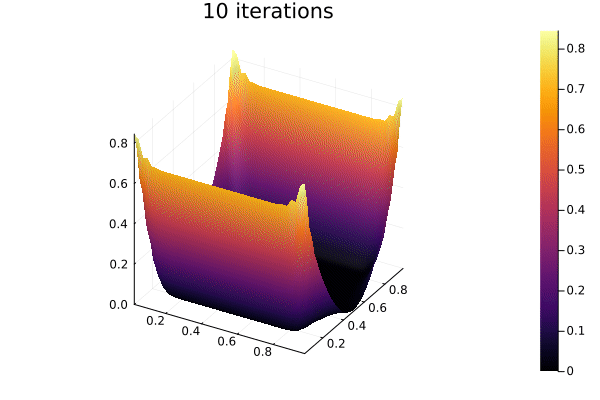

In [10]:
iterations = 10
n = 40
partition = 1/(n+1) : 1/(n+1) : 1-1/(n+1)

let b = matrix_rhs(n,f), u = zeros(n,n)
    @gif for i in 1:300
        u = gradient_descent(u,b,iterations)
        sgd = surface(partition,partition,u, title=string(i*iterations)*" iterations")
    end
end